In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer, scale
from sklearn.model_selection import KFold
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#directory='c:/users/da1933/desktop/cds/ids_project/'
directory='~/desktop/idsproject/'

df1=pd.read_csv(directory+'wine/winemag-data-130k-v2.csv',index_col=0)
#df=pd.read_csv(directory+'wine/winemag-data-130k-v2.csv',index_col=0)
#df=df.drop(['taster_name','taster_twitter_handle','title'],axis=1)
df2=pd.read_csv(directory+'wine/winemag-data_first150k.csv',index_col=0)
df=pd.concat([df1.drop(['taster_name','taster_twitter_handle','title'],axis=1),df2]).reset_index(drop=True)

In [3]:
df['over90']=df['points'].apply(lambda x: 1 if x>=90 else 0)
df['designation']=df['designation'].fillna('missing')
df['textlen']=df['description'].apply(lambda x: len(x))
df['textlen']=scale(df[['textlen']])
df['price']=df['price'].fillna(np.mean(df['price']))
df['price']=scale(df[['price']])

/Users/danielamaranto/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.


### Selective Categorical Feature Encoding

In [4]:
'''
plan
- encode country fully
- add missing to region2 and encode
- encode top ?? of variety
- province?
- continent instead of country?
'''

'\nplan\n- encode country fully\n- add missing to region2 and encode\n- encode top ?? of variety\n- province?\n'

In [5]:
varietals=df['variety'].value_counts().reset_index().rename(columns={'index':'Grape','variety':'Count'})
varieties=set(varietals[varietals['Count']>1000]['Grape'])

df['variety']=df['variety'].apply(lambda x: x if x in varieties else 'Other')

df['country']=df['country'].fillna('Other')

In [8]:
enc = OneHotEncoder(handle_unknown='ignore',categories=[list(set(df['country'])),list(set(df['variety']))])
enc.fit(df[['country','variety']])

OneHotEncoder(categorical_features=None,
       categories=[['France', 'New Zealand', 'Egypt', 'Greece', 'Bosnia and Herzegovina', 'Germany', 'Mexico', 'Italy', 'Chile', 'Turkey', 'Argentina', 'Lebanon', 'Croatia', 'Spain', 'Montenegro', 'Portugal', 'Israel', 'India', 'Canada', 'Czech Republic', 'Moldova', 'Romania', 'US-France', 'England', 'Bulg...Grigio', 'Gewürztraminer', 'Pinot Gris', 'Rhône-style Red Blend', 'White Blend', 'Merlot', 'Other']],
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)

In [9]:
newdf=pd.DataFrame(enc.transform(df[['country','variety']]).toarray(),columns=enc.get_feature_names().tolist())

for i in ['textlen','over90','points']:
    newdf[i]=df[i]

### Train-Test-Split

In [12]:
newdf=newdf.set_index(np.random.permutation(newdf.index.values)).sort_index()

# Determine split index:
split_index=int(np.round(newdf.shape[0]*.8))

# Assign training and testing datasets based on split index
train_df=newdf.iloc[:split_index,:]
test_df=newdf.iloc[split_index:,:]

trainX=train_df.drop(['over90','points'],axis=1)
trainY=train_df[['over90','points']]
testX=test_df.drop(['over90','points'],axis=1)
testY=test_df[['over90','points']]

### Cross Validation

In [13]:
def xVal(dataset, label_name, k,model):
    kf = KFold(n_splits=k)
    results=[]
    highest=0
    for train_idxs, test_idxs in kf.split(dataset.drop(label_name,1)):
        train=dataset.iloc[train_idxs]
        test=dataset.iloc[test_idxs]

        clf=model().fit(train.drop(label_name,1),train[label_name])
        auc=roc_auc_score(test[label_name], clf.predict_proba(test.drop(label_name,1))[:,1])
        score=clf.score(test.drop(label_name,axis=1),test[label_name])
        if score > highest:
            highest=score
            best_model=clf
        results.append((auc,score))
            
    return results,best_model

In [14]:
def plotAUC(truth, pred, lab):
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label= lab+' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")

# <h1><center>Models</center></h1>

## Classification

### 1) Naive Bayes  
#### a) Bernoulli

0.7314168743325027


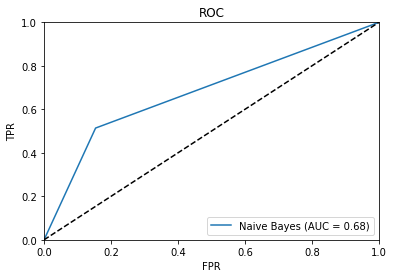

In [15]:
nb = BernoulliNB()
nb.fit(trainX, trainY['over90'])
nb_preds=nb.predict(testX)
print(nb.score(testX,testY['over90']))
plotAUC(testY['over90'],nb.predict(testX),'Naive Bayes')

#### b) Gaussian

0.3724457102171591


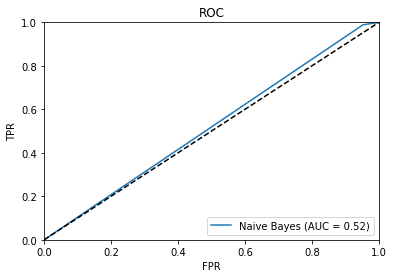

In [16]:
gnb = GaussianNB()
gnb.fit(trainX, trainY['over90'])
gnb_preds=gnb.predict(testX)
print(gnb.score(testX,testY['over90']))
plotAUC(testY['over90'],gnb.predict(testX),'Naive Bayes')

### 2) Logistic Regression

0.7563901744393022


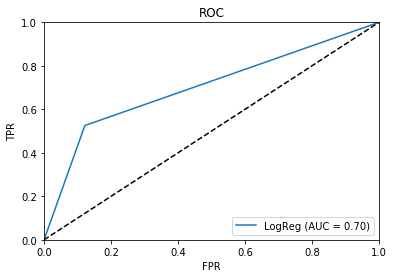

In [17]:
lr = LogisticRegression()
lr.fit(trainX,trainY['over90'])
lr_preds=lr.predict(testX)
print(lr.score(testX,testY['over90']))
plotAUC(testY['over90'],lr.predict(testX),'LogReg')

### 3) Decision Tree

0.7689035243859025


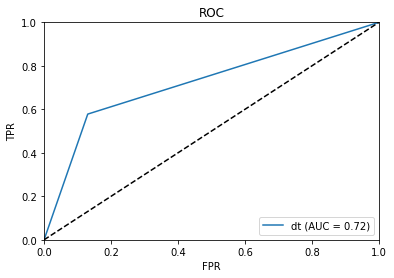

In [18]:
dt=DecisionTreeClassifier()
dt.fit(trainX,trainY['over90'])
dt_preds=dt.predict(testX)
print(dt.score(testX,testY['over90']))
plotAUC(testY['over90'],dt.predict(testX),'dt')

### 4) Random Forest Classifier

0.7671769312922748


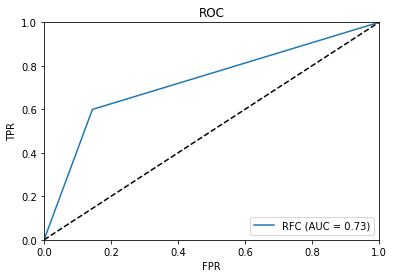

In [19]:
rfc=RandomForestClassifier(criterion='entropy')
rfc.fit(trainX,trainY['over90'])
rfc_preds=rfc.predict(testX)
print(rfc.score(testX,testY['over90']))
plotAUC(testY['over90'],rfc.predict(testX),'RFC')

### 5) Gradient Boosted Classifier

0.7546813812744749


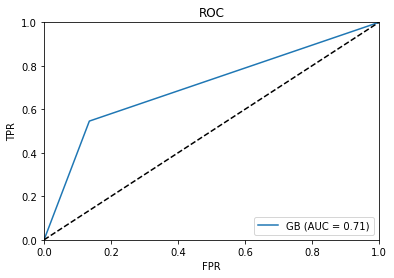

In [20]:
gbc=GradientBoostingClassifier()
gbc.fit(trainX,trainY['over90'])
gbc_preds=gbc.predict(testX)
print(gbc.score(testX,testY['over90']))
plotAUC(testY['over90'],gbc.predict(testX),'GB')

### To add later ? Analyze how/why models' predictions are different?

In [21]:
print('NB and LR make {0:.2f}% similar predictions'.format(100*sum(nb_preds==lr_preds)/len(testY['over90'])))
print('NB and DT make {0:.2f}% similar predictions'.format(100*sum(nb_preds==dt_preds)/len(testY['over90'])))
print('NB and RFC make {0:.2f}% similar predictions'.format(100*sum(nb_preds==rfc_preds)/len(testY['over90'])))
print('NB and GBC make {0:.2f}% similar predictions'.format(100*sum(nb_preds==gbc_preds)/len(testY['over90'])))
print('LR and DT make {0:.2f}% similar predictions'.format(100*sum(lr_preds==dt_preds)/len(testY['over90'])))
print('LR and RFC make {0:.2f}% similar predictions'.format(100*sum(lr_preds==rfc_preds)/len(testY['over90'])))
print('LR and GBC make {0:.2f}% similar predictions'.format(100*sum(lr_preds==gbc_preds)/len(testY['over90'])))
print('DT and RFC make {0:.2f}% similar predictions'.format(100*sum(dt_preds==rfc_preds)/len(testY['over90'])))
print('DT and GBC make {0:.2f}% similar predictions'.format(100*sum(dt_preds==gbc_preds)/len(testY['over90'])))
print('RFC and GBC make {0:.2f}% similar predictions'.format(100*sum(rfc_preds==gbc_preds)/len(testY['over90'])))

NB and LR make 86.45% similar predictions
NB and DT make 82.33% similar predictions
NB and RFC make 81.90% similar predictions
NB and GBC make 86.48% similar predictions
LR and DT make 86.39% similar predictions
LR and RFC make 85.85% similar predictions
LR and GBC make 95.54% similar predictions
DT and RFC make 96.33% similar predictions
DT and GBC make 86.72% similar predictions
RFC and GBC make 86.09% similar predictions


## Regression

### Random Forest Regression

In [22]:
mses=[]
d=[2**i for i in range(5,11)]
l=[2**i for i in range(11)]
for depth in d:
    for leaves in l:
        clf=RandomForestRegressor(max_depth=depth,min_samples_leaf=leaves)
        clf.fit(trainX,trainY['points'])
        mse=mean_squared_error(testY['points'],np.round(clf.predict(testX)))
        mses.append((depth,leaves,mse))
        print('Depth: {} Leaves: {} Mean Squared Error: {:.3f}'.format(depth,leaves,mse))

Depth: 32 Leaves: 1 Mean Squared Error: 5.442
Depth: 32 Leaves: 2 Mean Squared Error: 5.458
Depth: 32 Leaves: 4 Mean Squared Error: 5.505
Depth: 32 Leaves: 8 Mean Squared Error: 5.527
Depth: 32 Leaves: 16 Mean Squared Error: 5.565
Depth: 32 Leaves: 32 Mean Squared Error: 5.612
Depth: 32 Leaves: 64 Mean Squared Error: 5.673
Depth: 32 Leaves: 128 Mean Squared Error: 5.765
Depth: 32 Leaves: 256 Mean Squared Error: 5.890
Depth: 32 Leaves: 512 Mean Squared Error: 6.070
Depth: 32 Leaves: 1024 Mean Squared Error: 6.273
Depth: 64 Leaves: 1 Mean Squared Error: 5.489
Depth: 64 Leaves: 2 Mean Squared Error: 5.488
Depth: 64 Leaves: 4 Mean Squared Error: 5.507
Depth: 64 Leaves: 8 Mean Squared Error: 5.523
Depth: 64 Leaves: 16 Mean Squared Error: 5.564
Depth: 64 Leaves: 32 Mean Squared Error: 5.609
Depth: 64 Leaves: 64 Mean Squared Error: 5.664
Depth: 64 Leaves: 128 Mean Squared Error: 5.764
Depth: 64 Leaves: 256 Mean Squared Error: 5.893
Depth: 64 Leaves: 512 Mean Squared Error: 6.094
Depth: 64 Lea

In [28]:
#best model parameters:
best_model=mses[np.argmin([i[-1] for i in mses])]
print('Best Model Paramters: ',best_model)

Best Model Paramters:  (32, 1, 5.442452830188679)


In [29]:
# Best model:
clf=RandomForestRegressor(max_depth=best_model[0],min_samples_leaf=best_model[1])
clf.fit(trainX,trainY['points'])
preds=np.round(clf.predict(testX))
results=pd.DataFrame({'Predictions':preds,'Actual':testY['points']})
results=results.sort_values(by=['Actual']).reset_index(drop=True)

In [30]:
# Mean predictions for corresponding point level
sort=np.round(results.groupby(['Actual']).mean()).reset_index()
q={}
for i,v in enumerate(sort['Actual']):
    q[v]=sort['Predictions'][i]
results['MeanPreds']=results['Actual'].map(q)

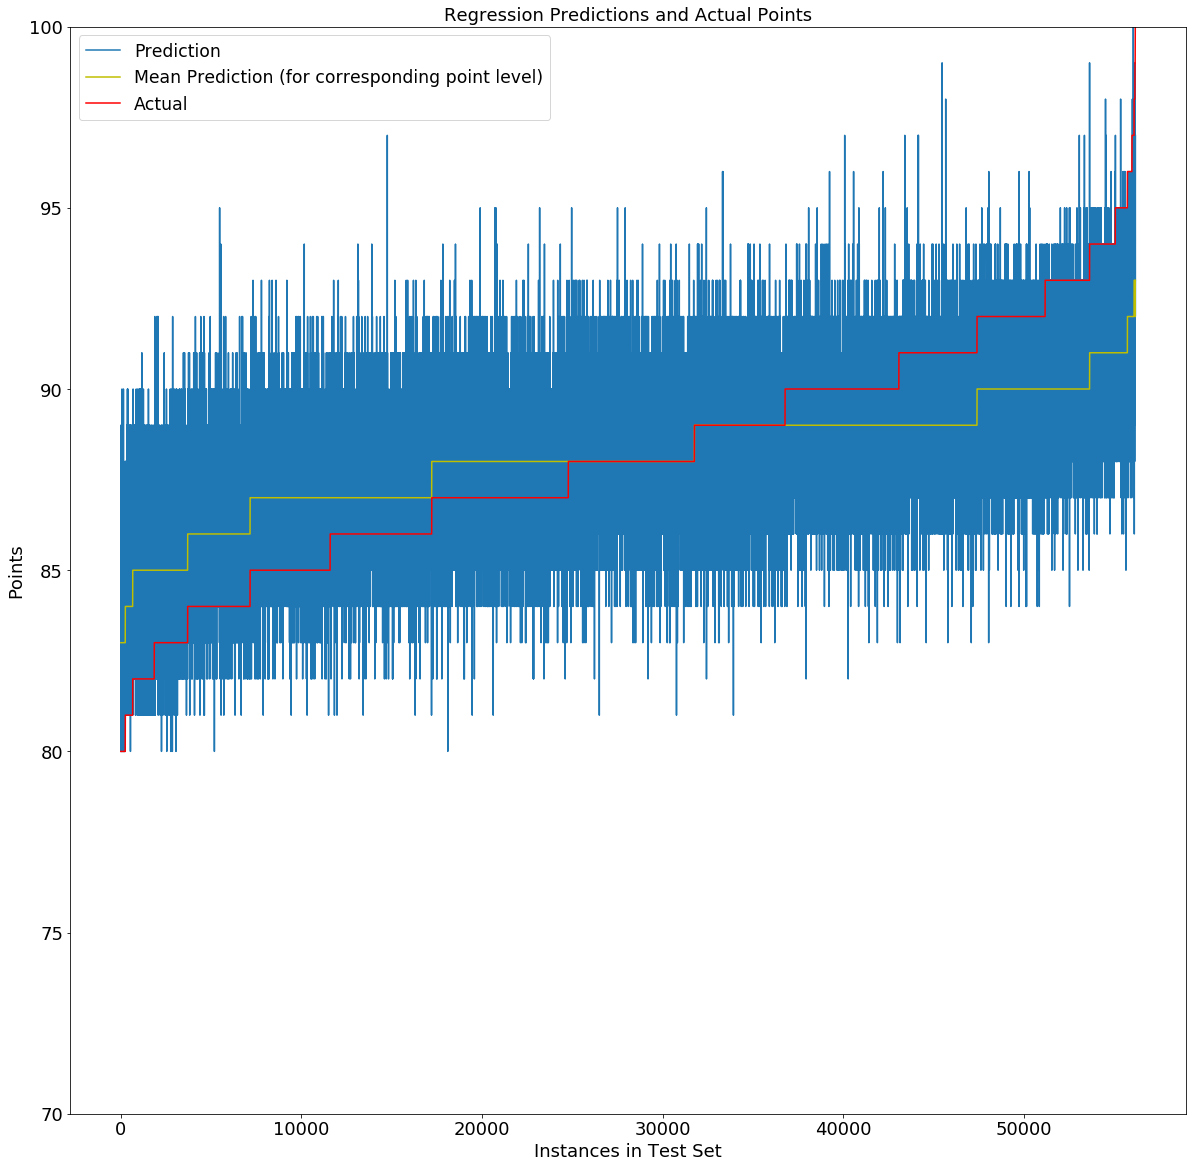

In [31]:
plt.figure(figsize=(20,20))
plt.plot(results['Predictions'],label='Prediction')
plt.plot(results['MeanPreds'],'y',label='Mean Prediction (for corresponding point level)')
plt.plot(results['Actual'],'r',label='Actual')
plt.ylim(70,100)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Points',fontsize=18)
plt.xlabel('Instances in Test Set',fontsize=18)
plt.title('Regression Predictions and Actual Points',fontsize=18)
plt.legend(fontsize='xx-large')